## Lunar Lander with REINFORCE
### Christian Igel, 2023

If you have suggestions for improvements, [let me know](mailto:igel@diku.dk).

Imports:

In [17]:
import gymnasium as gym

from tqdm.notebook import tqdm, trange  # Progress bar

import numpy as np
import matplotlib.pyplot as plt

We need [the `gymnasium` package](https://gymnasium.farama.org/).
From this package, we create the Cart-Pole game environment:

In [18]:
env_visual = gym.make('LunarLander-v3', render_mode="human")
action_size = 4
state_size = 8

Let's just test the environment first:

In [19]:
test_episodes = 5
for _ in range(test_episodes):
    R = 0
    state, _ = env_visual.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "truncated" to true after 500 steps 
        # Uncomment the line below to watch the simulation
        env_visual.render()
        state, reward, terminated, truncated, _ = env_visual.step(env_visual.action_space.sample()) #  Take a random action
        R += reward  # Accumulate reward
        if terminated or truncated:
            print("return: ", R)
            env_visual.reset()
            break

initial state: [-0.00267715  1.4072926  -0.2711754  -0.1612292   0.00310888  0.06142521
  0.          0.        ]
return:  -201.8668266272577
initial state: [ 0.00271082  1.4053016   0.2745658  -0.24970809 -0.00313442 -0.06219319
  0.          0.        ]
return:  -196.61222336830411
initial state: [-0.00499392  1.4114008  -0.50583905  0.02135376  0.00579343  0.11458005
  0.          0.        ]
return:  -182.2238922008355
initial state: [-0.00584831  1.4095372  -0.5923959  -0.06147711  0.00678363  0.13418661
  0.          0.        ]
return:  -147.0034465388597
initial state: [ 0.00682201  1.4013038   0.6909872  -0.42741966 -0.00789828 -0.15651874
  0.          0.        ]
return:  -174.80401532228294


## REINFORCE

Let's define a policy class for a simple softmax policy for real-valued feature vectors and discrete actions.
The preference for an action is just a linear function of the input features.
It is not trivial that this simple policy is powerful enough to solve the tasks without addional processing of the input features. However, it is indeed possible to get reasonable policies in this setting.

In [20]:
class Softmax_policy:
    def __init__(self, no_actions, no_features):
        """
        Initialize softmax policy for discrete actions
        :param no_actions: number of actions
        :param no_features: dimensionality of feature vector representing a state
        """        
        self.no_actions = no_actions
        self.no_features = no_features

        # Initialize policy parameters to zero
        self.theta = np.zeros([no_actions, no_features])
        
    def pi(self, s):
        """
        Compute action probabilities in a given state
        :param s: state feature vector
        :return: an array of action probabilities
        """
        # Compute action preferences for the given feature vector
        preferences = self.theta.dot(s)
        # Convert overflows to underflows
        preferences = preferences - preferences.max()
        # Convert the preferences into probabilities
        exp_prefs = np.exp(preferences)
        return exp_prefs / np.sum(exp_prefs)
    
    def inc(self, delta):
        """
        Change the parameters by addition, e.g. for initialization or parameter updates 
        :param delta: values to be added to parameters
        """
        self.theta += delta

    def sample_action(self, s):
        """
        Sample an action in a given state
        :param s: state feature vector
        :return: action
        """
        return np.random.choice(self.no_actions, p=self.pi(s))

    def gradient_log_pi(self, s, a):
        """
        Computes the gradient of the logarithm of the policy
        :param s: state feature vector
        :param a: action
        :return: gradient of the logarithm of the policy
        """
        # Compute the probability vector for state s
        prob = self.pi(s)
        # Compute the gradient for each action ( outer product of prob and s )
        grad = - np.outer(prob, s)
        # For the taken action a , add s to obtain (1 - pi (s , a ) ) * s
        grad[a] += s
        return grad

    def gradient_log_pi_test(self, s, a, eps=0.1):
        """
        Numerically approximates the gradient of the logarithm of the policy
        :param s: state feature vector
        :param a: action
        :return: approximate gradient of the logarithm of the policy
        """
        theta_correct = np.copy(self.theta)
        log_pi = np.log(self.pi(s)[a])
        d = np.zeros([self.no_actions, self.no_features])
        for i in range(self.no_actions):
            for j in range(self.no_features):
                self.theta[i,j] += eps
                log_pi_eps = np.log(self.pi(s)[a])
                d[i,j] = (log_pi_eps - log_pi) / eps
                self.theta = np.copy(theta_correct)
        return d
  
    
    

Verify gradient implementation:

In [21]:
env = gym.make('LunarLander-v3')
s = env.reset()[0]
pi = Softmax_policy(action_size, state_size)
tolerance = 0.001  # Absolute tolerance for difference in each gradient component
epsilon = 0.0001
for _ in range(10):
    pi.inc(10.*np.random.rand(action_size, state_size))
    for a in range(action_size):
        if not np.isclose(pi.gradient_log_pi(s, a), pi.gradient_log_pi_test(s, a, epsilon), atol=tolerance).all():
            print("derivative test for action", a)
            print(pi.gradient_log_pi(s, a))
            print(pi.gradient_log_pi_test(s, a))

Do the learning:

In [22]:
alpha = 0.00005  # Learning rate

no_episodes = 20000  # Number of episodes
total_reward_list = []  # Returns for the individual episodes
pi = Softmax_policy(action_size, state_size)  # Policy

# Do the learning
for e in trange(no_episodes):  #  Loop over episodes
    R = []  # Store rewards r_1, ..., r_T
    S = []  # Store actions a_0, ..., a_{T-1}
    A = []  # Store states s_0, ..., s_{T-1}
    state = env.reset()[0]  # Environment starts in a random state, cart and pole are moving
    while True:  # Environment sets "done" to true after 200 steps 
        S.append(state)
        
        action = pi.sample_action(state)  # Take an action following pi
        A.append(action)
        
        state, reward, terminated, truncated, _ = env.step(action)  # Observe reward and new state
        R.append(reward)
                
        if terminated or truncated:  # Failed or succeeded?
            break
            
    R = np.array(R)
    total_reward_list.append((e, R.sum()))
    
    for t in range(R.size):
        R_t = R[t:].sum()  # Accumulated future reward
        Delta = alpha * R_t * pi.gradient_log_pi(S[t], A[t])  # REINFORCE update
        pi.inc(Delta)  # Apply update
    

  0%|          | 0/20000 [00:00<?, ?it/s]

Plot learning process:

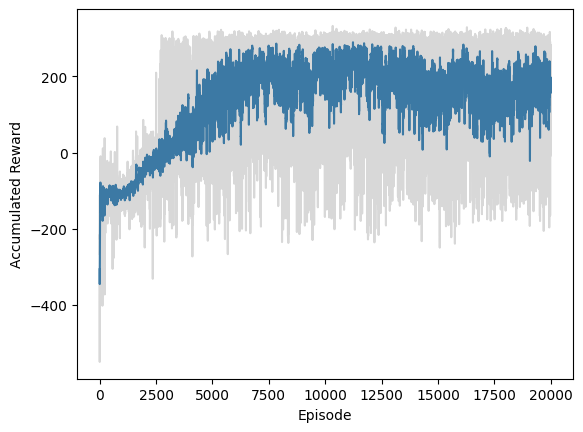

In [23]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, x[0]*np.ones(N)))
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(total_reward_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps, smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward');

Visualize policy:

In [ ]:
state = env_visual.reset()[0]  # Environment starts in a random state, cart and pole are moving
R = 0
while True:  # Environment sets "truncated" to true after 500 steps 
        env_visual.render()
        state, reward, terminated, truncated, _ = env_visual.step( pi.sample_action(state) ) #  Take a  action
        R += reward  # Accumulate reward
        if terminated or truncated:
            print("return: ", R)
            break

return:  288.53919252856906


: 